In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
import math
import keras
from keras import layers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.optimizers import schedules

<ipython-input-1-d74ce20e3c86>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


# Get data from: 
https://finance.yahoo.com/quote/TSLA/history?period1=1420070400&period2=1672531200&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

The data are from 2015 till now (2023) !

In [2]:
df = pd.read_csv("TSLA.csv")
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-03-03,292.923340,295.480011,277.533325,279.763336,279.763336,61623600
1,2022-03-04,283.033325,285.216675,275.053345,279.429993,279.429993,66999600
2,2022-03-07,285.433319,288.713318,268.190002,268.193329,268.193329,72494100
3,2022-03-08,265.176666,283.329987,260.723328,274.799988,274.799988,80399100
4,2022-03-09,279.826660,286.853333,277.336670,286.323334,286.323334,59184000


Target Variable: Close Value
Before building the ARIMA model, let’s see if there is some cross-correlation in out data.

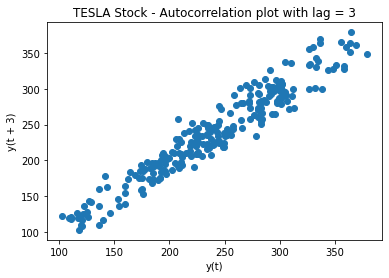

In [3]:
plt.figure()
lag_plot(df['Open'], lag=3)
plt.title('TESLA Stock - Autocorrelation plot with lag = 3')
plt.show()

Indeed there is auto_correlation in the data.
Let’s plot the stock price evolution over time.

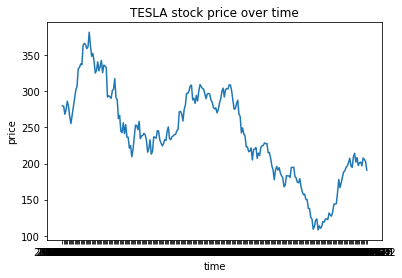

In [4]:
plt.plot(df["Date"], df["Close"])
plt.title("TESLA stock price over time")
plt.xlabel("time")
plt.ylabel("price")
plt.show()

We can see clearly that the data is non stationnary with a drift taking the price down and picks of volatility.

In [5]:
time_series_values = df['Close']

Visualizing the first difference of our close values give us:

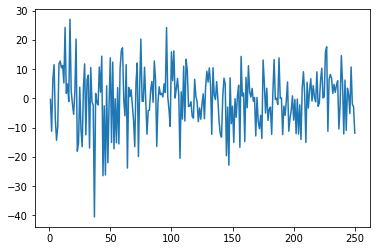

In [6]:
time_series_values_diff = time_series_values.diff().dropna()
plt.plot(time_series_values_diff)

# **Augmented Dickey-Fuller Test**

In [7]:
adfuller(time_series_values_diff)

(-3.6082538718237265,
 0.005605177939190099,
 8,
 241,
 {'1%': -3.4577787098622674,
  '5%': -2.873608704758507,
  '10%': -2.573201765981991},
 1710.9898512562804)

Since the p-value is far less than .05, we reject the null hypothesis.

This means the time series is stationary. In other words, it does not have some time-dependent structure and has constant variance over time. We can now try ARIMA model to predict future values of the differences of close values.

# **Autocorrelation Function (ACF)**

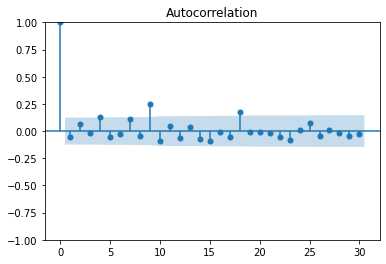

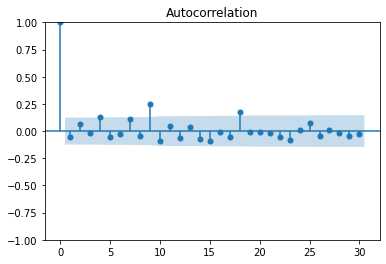

In [8]:
plot_acf(time_series_values_diff, lags = 30)

# **Partial Autocorrelation Function (PACF)**

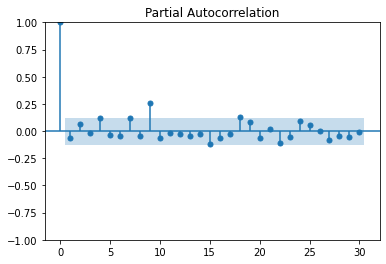

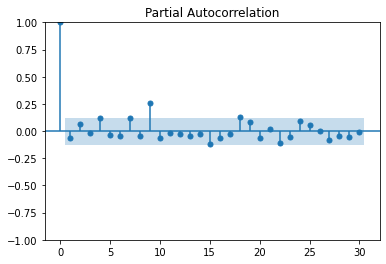

In [9]:
plot_pacf(time_series_values_diff, lags = 30, method = "ols")

Visualizing the acf and pacf of our close value, we may try ARMA(18,18) on the differences of close values. So we are modelling an ARIMA(18,1,18) on the close values.

In [10]:
%%time

train_data, test_data = df[0:int(len(df)*0.7)], df[int(len(df)*0.7):]
training_data = train_data['Close'].values
test_data = test_data['Close'].values
history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)

for time_point in range(N_test_observations):
    model = sm.tsa.arima.ARIMA(history, order=(18,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)

MSE_error = mean_squared_error(test_data, model_predictions)
print('Testing Mean Squared Error is {}'.format(MSE_error))
MAPE_error = mean_absolute_percentage_error(test_data, model_predictions)
print('Testing MAPE Error is {}'.format(MAPE_error))

Testing Mean Squared Error is 64.36170821035917
Testing MAPE Error is 0.04110643339734438
CPU times: user 1min 37s, sys: 1min 18s, total: 2min 56s
Wall time: 2min 16s


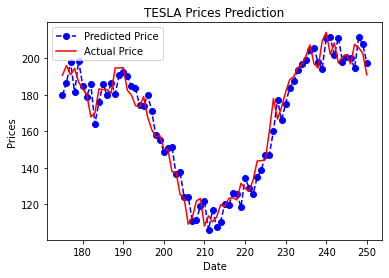

In [11]:
test_set_range = df[int(len(df)*0.7):].index
plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, test_data, color='red', label='Actual Price')
plt.title('TESLA Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()

# **LSTM Model**

**Data Preprocessing**

To build a LSTM model, we need to separate our stock prices data into a training set and a test set. Besides, we will also normalize our data so that all the values are ranged from 0 to 1.

In [39]:
close_prices = df['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.7)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

# Create a 30-days window of historical prices (i-30) as our feature data (x_train) and the following 30-days window as label data (y_train)

for i in range(30, len(train_data)):
    x_train.append(train_data[i-30:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [40]:
test_data = scaled_data[training_data_len-30: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(30, len(test_data)):
  x_test.append(test_data[i-30:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [41]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 30, 100)           40800     
                                                                 
 lstm_9 (LSTM)               (None, 100)               80400     
                                                                 
 dense_9 (Dense)             (None, 25)                2525      
                                                                 
 dense_10 (Dense)            (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [42]:
# lr_schedule = schedules.ExponentialDecay(initial_learning_rate=0.1,decay_steps=40,decay_rate=0.1)
# adam = Adam(learning_rate=lr_schedule)

sgd = SGD()

for i in range(0,3):
    adam = Adam(learning_rate=5*10**(-(2+2*i)))
    model.compile(optimizer=adam, loss='mean_absolute_percentage_error')
    # model.compile(optimizer=adam, loss='mean_squared_error')
    # model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, batch_size= 128, epochs=500*i)

Epoch 1/500
2/2 [==============================] - 6s 43ms/step - loss: 96.5663
Epoch 2/500
2/2 [==============================] - 0s 56ms/step - loss: 63.6899
Epoch 3/500
2/2 [==============================] - 0s 41ms/step - loss: 27.2815
Epoch 4/500
2/2 [==============================] - 0s 43ms/step - loss: 23.2579
Epoch 5/500
2/2 [==============================] - 0s 39ms/step - loss: 31.8346
Epoch 6/500
2/2 [==============================] - 0s 41ms/step - loss: 18.0041
Epoch 7/500
2/2 [==============================] - 0s 39ms/step - loss: 15.1507
Epoch 8/500
2/2 [==============================] - 0s 42ms/step - loss: 19.6736
Epoch 9/500
2/2 [==============================] - 0s 40ms/step - loss: 20.7104
Epoch 10/500
2/2 [==============================] - 0s 39ms/step - loss: 17.6739
Epoch 11/500
2/2 [==============================] - 0s 40ms/step - loss: 14.3035
Epoch 12/500
2/2 [==============================] - 0s 40ms/step - loss: 14.1440
Epoch 13/500
2/2 [===================

In [43]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
mse = np.mean(predictions - y_test)**2
rmse = np.sqrt(mse)
print('MAPE =', mean_absolute_percentage_error(y_test, predictions))
print('MSE =', mse)
print('RMSE =',rmse)

3/3 [==============================] - 1s 14ms/step
MAPE = 0.06416511767676279
MSE = 53.32789306737797
RMSE = 7.30259495435547


<ipython-input-44-d4202c9d2279>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


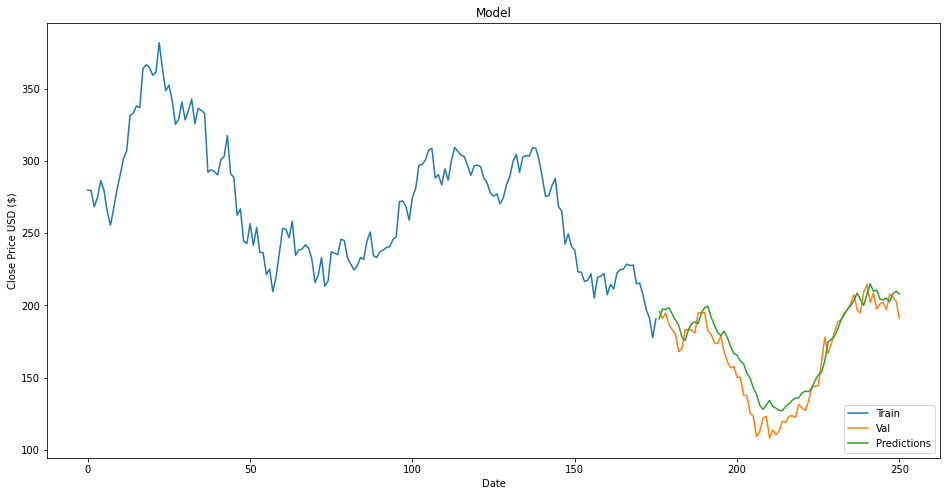

In [44]:
data = df.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()